## Set `UR5` Robot

In [1]:
import sys 
sys.path.append("..")
import cv2 
import numpy as np 
import time
import rospy
from sensor_msgs.msg import JointState
import matplotlib.pyplot as plt 
print("Done.")


Done.


### Define `UR` Class

In [2]:
class UR_Test():
    def __init__(self):
        self.tick = 0
        self.joint_list = None 
        self.joint_sub = rospy.Subscriber('/joint_states', JointState, self.joint_callback)

        tic_temp=0 

        while self.tick<2: 
            time.sleep(1e-3)
            tic_temp=tic_temp+1

            if tic_temp>5000: 
                print ("[ERROR] GET JOINTS")
                break 
            
    def joint_callback(self, joint_msg):
        """
            Get joint values about each joint.
        """
        self.tick+=1 
        self.joint_list = joint_msg 

#### You should run this line ahead.
`roslaunch ur_modern_driver ur5_bringup.launch robot_ip:=192.168.0.100`  in terminal.

In [3]:
rospy.init_node('test')
ur_test = UR_Test()

print(ur_test.joint_list.position)
joint_value = ur_test.joint_list.position

(-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105)


### Load Mujoco Engine

In [8]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import sample_xyzs,rpy2r,r2quat
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.4]


### Parse

In [9]:
xml_path = '../asset/ur5e/scene_ur5e_rg2_obj.xml'
env = MuJoCoParserClass(name='UR5e with RG2 gripper',rel_xml_path=xml_path,VERBOSE=True)
obj_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_"))]
n_obj = len(obj_names)
# Place objects in a row
xyzs = sample_xyzs(n_sample=n_obj,
                   x_range=[0.45,1.65],y_range=[-0.38,0.38],z_range=[0.81,0.81],min_dist=0.2)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
for obj_idx,obj_name in enumerate(obj_names):
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = xyzs[obj_idx,:]
    geomadr = env.model.body(obj_name).geomadr[0]
    env.model.geom(geomadr).rgba = colors[obj_idx] # color

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([1.05,0,0])
env.model.body('side_object_table').pos = np.array([0,-0.85,0])
env.model.body('base').pos = np.array([0,0,0.8])
print ("Ready.")

dt:[0.0020] HZ:[500]
n_body:[52]
geom_names:['floor', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
n_body:[29]
body_names:['world', 'base', 'shoulder_link', 'upper_arm_link', 'forearm_link', 'wrist_1_link', 'wrist_2_link', 'wrist_3_link', 'tcp_link', 'camera_mount', 'rg2_gripper_base_link', 'camera_center', 'rg2_gripper_finger1_finger_link', 'rg2_gripper_finger1_inner_knuckle_link', 'rg2_gripper_finger1_finger_tip_link', 'rg2_gripper_finger2_finger_link', 'rg2_gripper_finger2_inner_knuckle_link', 'rg2_gripper_finger2_finger_tip_link', 'front_object_table', 'side_object_table', 'base_table', 'obj_cylinder_01', 'obj_cylinder_02', 'obj_cylinder_03', 'obj_cylinder_04', 'obj_cylinder_05', 'obj_cylinder_06', 'obj_cylinder_07', 'obj_cyl

In [10]:
joint_names = env.rev_joint_names[:6]
idxs_forward = [env.model.joint(joint_name).qposadr[0] for joint_name in env.joint_names[:6]]
idxs_jacobian = [env.model.joint(joint_name).dofadr[0] for joint_name in env.joint_names[:6]]
list1, list2 = env.ctrl_joint_idxs, idxs_forward
idxs_step = []
for i in range(len(list2)):
    if list2[i] not in list1:
        idxs_step.append(list1.index(list2[i]))
        

In [11]:
joint_value = [-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105]

### Solve Inverse Kinematics on `Mujoco Engine`

In [12]:
R_trgt = rpy2r(np.radians([-180,0,90]))

q_ik = env.solve_ik(
    body_name='tcp_link',p_trgt=np.array([0.7, -0.2, 1.20]),R_trgt=R_trgt,
    IK_P=True,IK_R=True, q_init=np.array(joint_value),idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
    RESET=False,DO_RENDER=False,render_every=10,th=1*np.pi/180.0,err_th=1e-3)

print(q_ik)

[-0.72 -1.19  1.9   2.42 -0.85 -3.14]


Pressed ESC
Quitting.


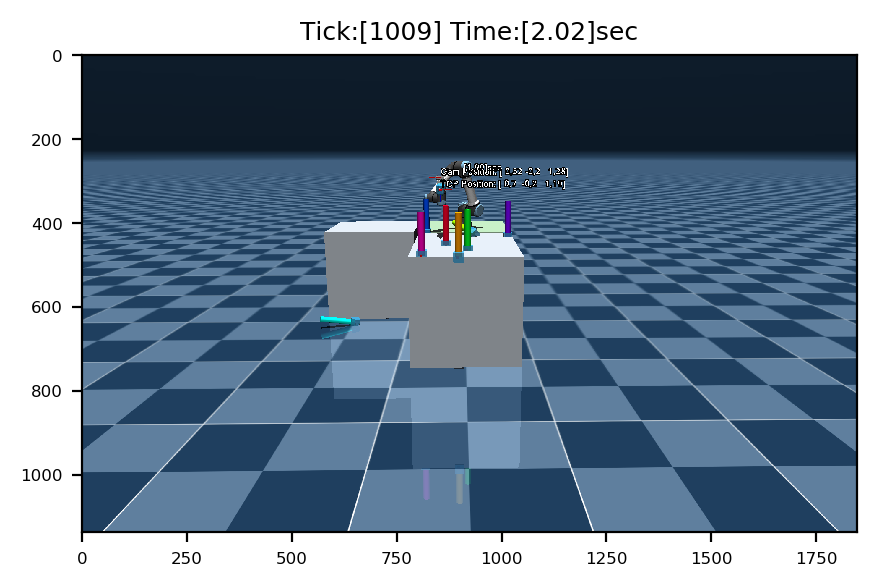

Done.


In [14]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=174.08,distance=2.76,elevation=-33,lookat=[0.1,0.05,0.16],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    env.step(ctrl=q_ik, ctrl_idxs=idxs_forward)
    # Render
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    p_cam,R_cam = env.get_pR_body(body_name='camera_center')
    p_base,R_base = env.get_pR_body(body_name='base')
    # env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'TCP Position: {p_tcp}')
    env.plot_T(p=p_cam,R=R_cam,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'Cam Position: {p_cam}')
    # env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_base+np.array([0,0,0.5]),R=np.eye(3,3),
                PLOT_AXIS=False,label='[%.2f]sec'%(env.get_sim_time()))
    env.render()
    if env.loop_every(HZ=1) or (tick == 1):
        scene_img = env.grab_image()
# Plot an image
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.")

qvel_deg:[120.00]deg/sec L_interp:[3119] HZ:[500] time_max:[6.24]sec


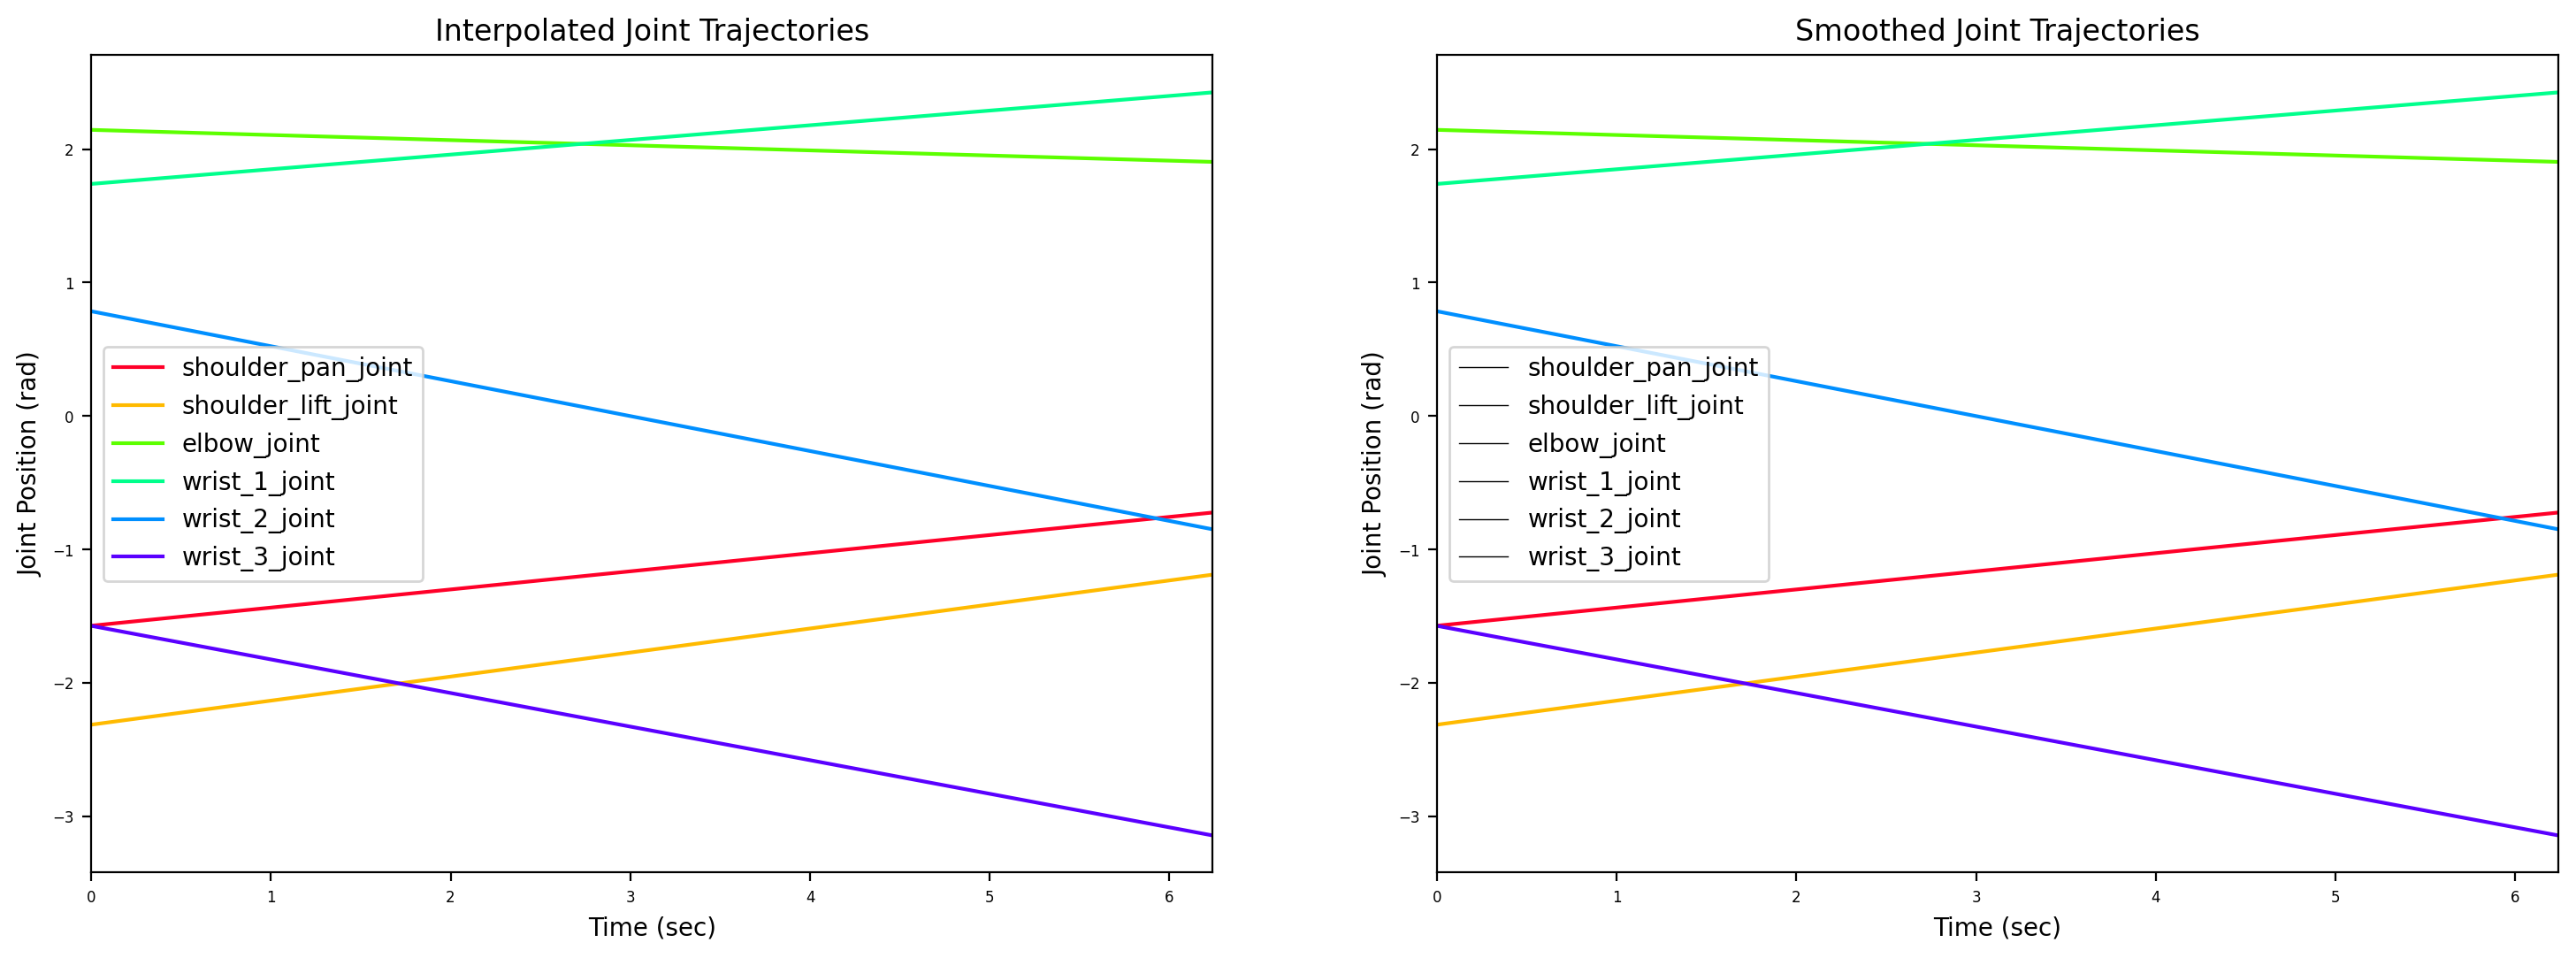

In [13]:
from util import get_interp_const_vel_traj
from grpp import GaussianRandomPathClass, kernel_levse

# desired joint velocity (deg/sec)
qvel_rad = np.deg2rad(120)
HZ = 500

times,q_traj = get_interp_const_vel_traj(
    (np.vstack([joint_value, q_ik])),
    vel=np.radians(15),HZ=env.HZ)
L_interp = q_traj.shape[0]
print ("qvel_deg:[%.2f]deg/sec L_interp:[%d] HZ:[%d] time_max:[%.2f]sec"%
       (np.rad2deg(qvel_rad),L_interp,HZ,times[-1]))

G = GaussianRandomPathClass(name='LGRP',kernel=kernel_levse)
G.set_data(t_anchor    = times.reshape((-1,1)),
           x_anchor    = q_traj,
           l_anchor    = np.ones((len(times),1)),
           t_test      = times.reshape((-1,1)),
           l_test      = np.ones((len(times),1)),
           hyp_mean    = {'g':1.0,'l':1.0,'w':1e-6},
           hyp_var     = {'g':1.0,'l':1.0,'w':1e-6},
           APPLY_EPSRU = False
          )

qs_smooth = G.mean_test

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,env.n_ctrl)])
for d_idx in range(env.n_ctrl-1):
    color=colors[d_idx,:]
    plt.plot(times,qs_smooth[:,d_idx],'-',color=color,
             label='%s'%(env.rev_joint_names[d_idx]))
plt.xlabel('Time (sec)'); plt.ylabel('Joint Position (rad)')
plt.title("Interpolated Joint Trajectories")
plt.xlim(0,times[-1]); plt.legend(fontsize=10); 
# plt.show()

# plt.figure(figsize=(8,3))
plt.subplot(1,2,2)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,env.n_ctrl)])
for d_idx in range(env.n_ctrl-1):
    color=colors[d_idx,:]
    plt.plot(times,qs_smooth[:,d_idx],'-',color='k',lw=1/2,
             label='%s'%(env.rev_joint_names[d_idx]))
    plt.plot(times,qs_smooth[:,d_idx],'-',color=color)
plt.xlabel('Time (sec)'); plt.ylabel('Joint Position (rad)')
plt.title("Smoothed Joint Trajectories")
plt.xlim(0,times[-1]); plt.legend(fontsize=10); plt.show()

### And then, Execute on `Real-Robot`

In [14]:
import roslib; roslib.load_manifest('ur_driver')
import rospy
import actionlib
from control_msgs.msg import *
from trajectory_msgs.msg import *
from sensor_msgs.msg import JointState
""" FOR ONROBOT RG2 """
from pymodbus.client.sync import ModbusTcpClient
import math

In [15]:
# TODO: Implement about RealRobot Class.
class RealRobot:
    def __init__(self):
        self.client = None
        self.JOINT_NAMES = ['shoulder_pan_joint', 'shoulder_lift_joint', 'elbow_joint',
                            'wrist_1_joint', 'wrist_2_joint', 'wrist_3_joint']
        self.arm_pub     = rospy.Publisher('arm_controller/command', JointTrajectory, queue_size = 10)

    def main(self, joint_list=None): 
        try: 
            # rospy.init_node("test_move", anonymous=True, disable_signals=True)
            self.client = actionlib.SimpleActionClient('follow_joint_trajectory', FollowJointTrajectoryAction)
            print("Waiting for server...")
            self.client.wait_for_server()
            print("Connected to server")
            parameters = rospy.get_param(None)
            index = str(parameters).find('prefix')
            if (index > 0):
                prefix = str(parameters)[index+len("prefix': '"):(index+len("prefix': '")+str(parameters)[index+len("prefix': '"):-1].find("'"))]
                for i, name in enumerate(self.JOINT_NAMES):
                    self.JOINT_NAMES[i] = prefix + name
            self.move_trajectory(joint_list=joint_list)

        except KeyboardInterrupt:
            rospy.signal_shutdown("KeyboardInterrupt")
            raise

    def move_trajectory(self, joint_list):
        g = FollowJointTrajectoryGoal()
        g.trajectory = JointTrajectory()
        g.trajectory.joint_names = self.JOINT_NAMES
        for i, q in enumerate(joint_list):
            if i==0:
                joint_states = rospy.wait_for_message("joint_states", JointState)
                joints_pos   = joint_states.position
                g.trajectory.points = [
                    JointTrajectoryPoint(positions=joints_pos, velocities=[0]*6, time_from_start=rospy.Duration(0.0)),
                    JointTrajectoryPoint(positions=q, velocities=[0]*6, time_from_start=rospy.Duration(3))]  
                d=3
            else:
                vel = (q-prev_q) #num_interpol # TODO: CHECK VELOCITY
                g.trajectory.points.append(
                    JointTrajectoryPoint(positions=q, velocities=vel,time_from_start=rospy.Duration(d))) 
            prev_q = q
            d+=0.002
        try:
            print("MOVE")
            self.client.send_goal(g)
            self.client.wait_for_result()
        except:
            raise

    def move_capture_pose(self): 
        try: 
            # rospy.init_node("test_move", anonymous=True, disable_signals=True)
            self.client = actionlib.SimpleActionClient('follow_joint_trajectory', FollowJointTrajectoryAction)
            print("Waiting for server...")
            self.client.wait_for_server()
            print("Connected to server")
            parameters = rospy.get_param(None)
            index = str(parameters).find('prefix')
            if (index > 0):
                prefix = str(parameters)[index+len("prefix': '"):(index+len("prefix': '")+str(parameters)[index+len("prefix': '"):-1].find("'"))]
                for i, name in enumerate(self.JOINT_NAMES):
                    self.JOINT_NAMES[i] = prefix + name
            self.capture_pose()

        except KeyboardInterrupt:
            rospy.signal_shutdown("KeyboardInterrupt")
            raise

    def capture_pose(self):
        try: 
            q = [(-90)/180*math.pi, (-132.46)/180*math.pi, (122.85)/180*math.pi, (99.65)/180*math.pi, (45)/180*math.pi, (-90.02)/180*math.pi]
            g = FollowJointTrajectoryGoal()
            g.trajectory = JointTrajectory()
            g.trajectory.joint_names = self.JOINT_NAMES
            joint_states = rospy.wait_for_message("joint_states", JointState)
            joints_pos   = joint_states.position
            g.trajectory.points = [
                JointTrajectoryPoint(positions=joints_pos, velocities=[0]*6, time_from_start=rospy.Duration(0.0)),
                JointTrajectoryPoint(positions=q, velocities=[0]*6, time_from_start=rospy.Duration(3))]  
            self.client.send_goal(g)
            self.client.wait_for_result()
        except KeyboardInterrupt:
            self.client.cancel_goal()
            raise
        except:
            raise

def euclidean_dist(point1, point2):
    return math.sqrt(sum([math.pow(point1[i] - point2[i], 2) for i in range(len(point1))]))

def get_desired_time(start_pos, target_pos, desired_vel): 
    length = euclidean_dist(start_pos, target_pos)    
    desired_time = length/desired_vel
    return desired_time

In [16]:
real_robot = RealRobot()


In [ ]:
desried_time = get_desired_time(anchor=traj_lst[int(selection)-1],anchor_t=traj_time, desired_vel=0.2)
interpoled_q = ik_robot.get_interp_np_traj(anchor=sel_traj, anchor_time=traj_time, desired_time=desried_time)


In [17]:
# Set to Initial Pose.
real_robot.move_capture_pose();time.sleep(1)


Waiting for server...
Connected to server


In [18]:
real_robot.main(joint_list=qs_smooth)


Waiting for server...
Connected to server
MOVE


### Move `Gripper`

In [21]:
import sys
sys.path.append("..")
import rospy
import numpy as np
import math
import time
import argparse 
import subprocess
from pathlib import Path
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
""" FOR ONROBOT RG2 """
from pymodbus.client.sync import ModbusTcpClient
""" FOR MODERN DRIVER """
import roslib; roslib.load_manifest('ur_driver')
import rospy
from gripper import openGrasp, closeGrasp

def main(): 
    graspclient = ModbusTcpClient('192.168.0.22') 
    closeGrasp(force=200, width=100, graspclient=graspclient)
    # openGrasp(force=200, width=700, graspclient=graspclient)

main()